## Art Dating

#### Students
- Zhenbang Chen
- Zhenjia Chen

### Setup

Importing packages and dependencies.  Load dataset for categorization.

In [1]:
import os
import copy
from PIL import Image
rootpath = "."

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm.auto import tqdm
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2
Using the GPU!


### Model Initialization

In [3]:
def initialize_model(num_classes, resume_from=None):
    
    if resume_from:
        model_ft = models.resnet50(pretrained = False)
        
        in_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features, num_classes)
        
        model_ft.load_state_dict(torch.load(resume_from))
        
        return model_ft
    else:
        # Model (nn.Module) to return
        # model_ft = models.resnet18(pretrained = false)
        model_ft = models.resnet50(pretrained=True)

        in_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features, num_classes)

        return model_ft

### Tests

In [4]:
# Transform to apply to the data
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
# ])

# Transform to apply to the data for use with pretrained ResNet model
transform = torchvision.transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# Get training data from directory
art_train = torchvision.datasets.ImageFolder(root="./data/art_culture_train",
                                                 transform=transform)

# Get testing data from directory
art_val = torchvision.datasets.ImageFolder(root="./data/art_culture_val",
                                               transform=transform)

art_test = torchvision.datasets.ImageFolder(root="./data/art_culture_test",
                                               transform=transform)

In [6]:
# Create random sampler
random_sampler = torch.utils.data.RandomSampler(data_source=art_train,
                                                replacement=True,
                                                num_samples=int(len(art_train)/10))

# Create batched dataloader
art_train_loader = torch.utils.data.DataLoader(dataset=art_train,
                                                   batch_size=8,
                                                   shuffle=True,
                                                   num_workers=4,
                                                   pin_memory=True)

# art_train_loader = torch.utils.data.DataLoader(dataset=art_train,
#                                                    batch_size=8,
#                                                    sampler=random_sampler,
#                                                    shuffle=False,
#                                                    num_workers=4,
#                                                    pin_memory=True)

art_val_loader = torch.utils.data.DataLoader(dataset=art_val,
                                                 batch_size=8,
                                                 shuffle=False,
                                                 num_workers=4,
                                                 pin_memory=True)

art_test_loader = torch.utils.data.DataLoader(dataset=art_test,
                                                 batch_size=8,
                                                 shuffle=False,
                                                 num_workers=4,
                                                 pin_memory=True)

### Initialization and Methods

In [7]:
# Initialize model
# model = torchvision.models.resnet18(pretrained=False)
# model = torchvision.models.resnet50(pretrained=True)

# Set number of output classes
# model.conv1 = nn.Conv2d(in_channels=3,
#                         out_channels=64,
#                         kernel_size=(7,7),
#                         stride=(2,2),
#                         padding=(3,3),
#                         bias=False)

# in_features = model.fc.in_features
# out_features = 11
# model.fc = nn.Linear(in_features, out_features)

# model = model.to(device)

model = initialize_model(num_classes=11).to(device)

In [8]:
# Training method
def train(net, optim, criterion,train_loader):
    net.train()
    for image_cpu, label_cpu in tqdm(train_loader):
        # Move image and label to GPU
        image = image_cpu.to(device)
        label = label_cpu.to(device)
        
        # Clear gradient
        optim.zero_grad()
        
        # Forward through the network
        output = net(image)
        
        # Loss and gradient
        loss = criterion(output, label)
        loss.backward()
        
        # Update paramters
        optim.step()

In [9]:
# Evaluation method
def evaluate(net, val_loader, top_n=1):
    total = 0
    correct = 0
    net.eval()
    
    for image_cpu, label_cpu in tqdm(val_loader):
        # Move image and label to GPU
        image = image_cpu.to(device)
        label = label_cpu.to(device)
        
        # Don't track gradients for performance in evaluation
        with torch.no_grad():
            # Get prediction with forward pass
            prediction = net(image).argmax(dim=-1)
            
            # Get the indices of the top_n predictions
#             prediction = net(image).topk(k=top_n, dim=-1)[1]
            
            # Total number in batch
            total += image.size(0)
            
            # Number correct in batch
            correct += (prediction == label).sum().item()
            
    return correct/total

In [10]:
# Validation method
def validate(net, criterion, val_loader):
    total = 0
    running_loss = 0
    correct = 0
    net.eval()
    
    for image_cpu, label_cpu in tqdm(val_loader):
        # Move image and label to GPU
        image = image_cpu.to(device)
        label = label_cpu.to(device)
        
        # Don't track gradients for performance in validation
        with torch.no_grad():
            # Forward through the network
            output = net(image)
            
            # Get prediction with forward pass
            prediction = output.argmax(dim=-1)

            # Loss and gradient
            loss = criterion(output, label)
            
            # Total number in batch
            total += image.size(0)
            
            # Accumulate loss
            running_loss += loss.item()
            
            # Number correct in batch
            correct += (prediction == label).sum().item()
            
    return running_loss/total, correct/total

### Training

In [12]:
# Create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Create criterion
criterion = torch.nn.functional.cross_entropy

# Create scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode="min",
                                                 factor=0.2,
                                                 patience=1,
                                                 verbose=True,
                                                 threshold=0.01)

In [13]:
# Start training
num_epochs = 30

print("start")

best_state_dict = {}
best_val_acc = 0
for epoch in range(num_epochs):
    print("Epoch {}".format(epoch))
#     val_acc = evaluate(model, art_val_loader) * 100
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_state_dict = copy.deepcopy(model.state_dict())
    
    train(model, optimizer, criterion, art_train_loader)
    val_loss, val_acc = validate(model, criterion, art_val_loader)
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = copy.deepcopy(model.state_dict())
    
    print("Val Loss - Epoch {}: {}".format(epoch, val_loss))
    print("Val Acc - Epoch {}: {}%".format(epoch, val_acc))
    
    if epoch % 4 == 0 and epoch != 0:
        torch.save(best_state_dict, "./models/art_culture_temp_epoch" + str(epoch))
    
print("Done! {}%".format(evaluate(model, art_val_loader) * 100))

start
Epoch 0



Val Loss - Epoch 0: 0.17156956945841406
Val Acc - Epoch 0: 0.5574018126888217%
Epoch 1



Val Loss - Epoch 1: 0.15322135645457266
Val Acc - Epoch 1: 0.5876132930513596%
Epoch 2



Val Loss - Epoch 2: 0.14194117666551354
Val Acc - Epoch 2: 0.6042296072507553%
Epoch 3



Val Loss - Epoch 3: 0.13434941999141542
Val Acc - Epoch 3: 0.6359516616314199%
Epoch 4



Val Loss - Epoch 4: 0.13228035706947938
Val Acc - Epoch 4: 0.6359516616314199%
Epoch 5



Val Loss - Epoch 5: 0.1293873668527315
Val Acc - Epoch 5: 0.6540785498489426%
Epoch 6



Val Loss - Epoch 6: 0.1250571974994913
Val Acc - Epoch 6: 0.6661631419939577%
Epoch 7



Val Loss - Epoch 7: 0.12304008569782234
Val Acc - Epoch 7: 0.6722054380664653%
Epoch 8



Val Loss - Epoch 8: 0.12198283831698657
Val Acc - Epoch 8: 0.6631419939577039%
Epoch 9



Epoch     9: reducing learning rate of group 0 to 2.0000e-04.
Val Loss - Epoch 9: 0.12548691425978958
Val Acc - Epoch 9: 0.676737160120846%
Epoch 10



Val Loss - Epoch 10: 0.12557875614872152
Val Acc - Epoch 10: 0.6691842900302115%
Epoch 11



Epoch    11: reducing learning rate of group 0 to 4.0000e-05.
Val Loss - Epoch 11: 0.12844593714911412
Val Acc - Epoch 11: 0.6631419939577039%
Epoch 12



Val Loss - Epoch 12: 0.12411121798966226
Val Acc - Epoch 12: 0.6722054380664653%
Epoch 13



Epoch    13: reducing learning rate of group 0 to 8.0000e-06.
Val Loss - Epoch 13: 0.12561322541575418
Val Acc - Epoch 13: 0.676737160120846%
Epoch 14



Val Loss - Epoch 14: 0.12682414225941338
Val Acc - Epoch 14: 0.6691842900302115%
Epoch 15



Epoch    15: reducing learning rate of group 0 to 1.6000e-06.
Val Loss - Epoch 15: 0.12672053669154465
Val Acc - Epoch 15: 0.6631419939577039%
Epoch 16



Val Loss - Epoch 16: 0.1278635028896015
Val Acc - Epoch 16: 0.6691842900302115%
Epoch 17



Epoch    17: reducing learning rate of group 0 to 3.2000e-07.
Val Loss - Epoch 17: 0.12659793353873078
Val Acc - Epoch 17: 0.6691842900302115%
Epoch 18



Val Loss - Epoch 18: 0.12509634528095268
Val Acc - Epoch 18: 0.6782477341389728%
Epoch 19



Epoch    19: reducing learning rate of group 0 to 6.4000e-08.
Val Loss - Epoch 19: 0.12580852975838133
Val Acc - Epoch 19: 0.6812688821752266%
Epoch 20



Val Loss - Epoch 20: 0.125800215630733
Val Acc - Epoch 20: 0.676737160120846%
Epoch 21



Epoch    21: reducing learning rate of group 0 to 1.2800e-08.
Val Loss - Epoch 21: 0.1238450273376217
Val Acc - Epoch 21: 0.6782477341389728%
Epoch 22



Val Loss - Epoch 22: 0.1251374650127578
Val Acc - Epoch 22: 0.6737160120845922%
Epoch 23



Epoch    23: reducing learning rate of group 0 to 2.5600e-09.
Val Loss - Epoch 23: 0.12321834563308612
Val Acc - Epoch 23: 0.6706948640483383%
Epoch 24



Val Loss - Epoch 24: 0.12837690164495452
Val Acc - Epoch 24: 0.6555891238670695%
Epoch 25



Val Loss - Epoch 25: 0.12729115914722225
Val Acc - Epoch 25: 0.6601208459214502%
Epoch 26



Val Loss - Epoch 26: 0.1212956696928808
Val Acc - Epoch 26: 0.6948640483383686%
Epoch 27



Val Loss - Epoch 27: 0.12289285308644851
Val Acc - Epoch 27: 0.6842900302114804%
Epoch 28



Val Loss - Epoch 28: 0.12807989395096944
Val Acc - Epoch 28: 0.6737160120845922%
Epoch 29



Val Loss - Epoch 29: 0.12449260166314434
Val Acc - Epoch 29: 0.675226586102719%



Done! 67.5226586102719%


In [14]:
# Save model
torch.save(best_state_dict, "./models/art_culture_platlr0001_fac02_pat1_thres001_epoch30")

### Testing

In [15]:
# Load the model to test
model = initialize_model(num_classes=11,
                         resume_from="./models/art_culture_platlr0001_fac02_pat1_thres001_epoch30").to(device)

test_acc = evaluate(model, art_test_loader)
print("Done!", test_acc)


Done! 0.7190332326283988


### Miscellaneous

In [88]:
culture_categories = {
    0 : "american",
    1 : "british",
    2 : "chinese",
    3 : "dutch",
    4 : "flemish",
    5 : "french",
    6 : "german",
    7 : "indian",
    8 : "italian",
    9 : "japanese",
    10 : "spanish"
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ 0,  1,  5, 10,  6,  3,  4,  8,  7,  9,  2]], device='cuda:0')
american


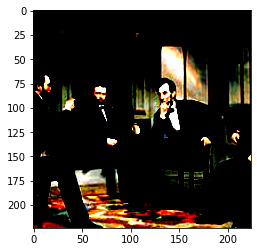

In [106]:
# Test on one specific example

# from torch.autograd import Variable
import matplotlib.pyplot as plt

def load_image(image_name):
    """Loads an image; returns a batched image tensor"""
    image = Image.open(image_name).convert("RGB")
#     plt.imshow(image)
    
    image = transform(image)
    
    plt.imshow(image.permute(1,2,0))
    
    image = image.clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image


def classify_image(model, categories, image_name):
    '''Classify an image using a specified model'''
    model.eval()
    image = load_image(image_name).to(device)
    result_vec = model(image)
    print(result_vec.sort(descending=True)[1])
    top_result = result_vec.argmax(dim=-1).item()
    
    return categories[top_result]

model = initialize_model(num_classes=11,
                         resume_from="./models/art_culture_platlr0001_fac02_pat1_thres001_epoch30").to(device)

culture = "british"
image_index = "262"

print(classify_image(model,
                     culture_categories,
                     "peacemakers.jpg"))

# print(classify_image(model,
#                      culture_categories,
#                      "./data/art_culture_all_filtered/" + culture + "/" + str(image_index) + ".jpg"))

In [ ]:
# Get testing data from directory
letters_val = torchvision.datasets.ImageFolder(root="./data/text_val",
                                               transform=transform)

letters_val_loader = torch.utils.data.DataLoader(dataset=letters_val,
                                                 batch_size=512,
                                                 shuffle=False,
                                                 num_workers=4,
                                                 pin_memory=True)

# Initialize model
model = torchvision.models.resnet18(pretrained=False)
# model = torchvision.models.resnet50(pretrained=False)

# Set number of output classes
model.conv1 = nn.Conv2d(in_channels=3,
                        out_channels=64,
                        kernel_size=(7,7),
                        stride=(2,2),
                        padding=(3,3),
                        bias=False)

in_features = model.fc.in_features
out_features = 26
model.fc = nn.Linear(in_features, out_features)

model = model.to(device)
model.load_state_dict(torch.load("./models/letter_model_lr01_gamma015_e12"))

val_acc = evaluate(model, letters_val_loader) * 100
print("Done!", val_acc)